# 📘 Optimizing Battery Efficiency Across Devices and Usage Patterns

### Motivation
Portable devices are critical to modern life. Efficient battery usage improves both user experience and hardware longevity. This project aims to analyze how various features like brightness, CPU load, and temperature influence battery performance.

---

## 📂 Dataset Overview
The dataset includes the following columns:
- Date of Measurement
- Device Model
- Operating System Version
- Task Type
- Brightness Level (%)
- Battery Life (hours:minutes)
- Battery Health (%)
- Device Temperature (°C)
- CPU Utilization (%)
- Memory Usage (% RAM)


## 🔧 Data Preprocessing

In [5]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("battery_efficiency_data.csv")

def convert_to_minutes(val):
    if pd.isna(val): return np.nan
    hours, minutes = map(int, val.split(":"))
    return hours * 60 + minutes

df["Battery Life (min)"] = df["Battery Life (hours:minutes)"].apply(convert_to_minutes)
df.drop(columns=["Battery Life (hours:minutes)"], inplace=True)
df.dropna(inplace=True)
df_encoded = pd.get_dummies(df, columns=["Device Model", "Operating System Version", "Task Type"])
cleaned_df = df_encoded.copy()
df.head()


,Date of Measurement,Device Model,Operating System Version,Task Type,Brightness Level (%),Battery Health (%),Device Temperature (°C),CPU Utilization (%),Memory Usage (% RAM),Battery Life (min)
0,2025-04-09,iPhone 15 Pro,ios 17.4,Idle,28,85,49.7,45,47,396
1,2025-04-16,Pixel 7,ios 17.4,Streaming,90,94,42.6,50,75,319
2,2025-04-25,"MacBook Pro 14""",Android 13,Gaming,79,85,48.4,50,38,156
3,2025-04-10,Galaxy S22,Windows 11 23H2,Gaming,77,93,45.7,60,46,479
4,2025-04-14,"MacBook Pro 14""",Windows 11 23H2,Idle,90,85,54.3,87,45,304


In [4]:
from google.colab import files
uploaded = files.upload()


Saving battery_efficiency_data.csv to battery_efficiency_data.csv


## 📊 Exploratory Data Analysis (EDA)
### 🔋 Battery Life Distribution

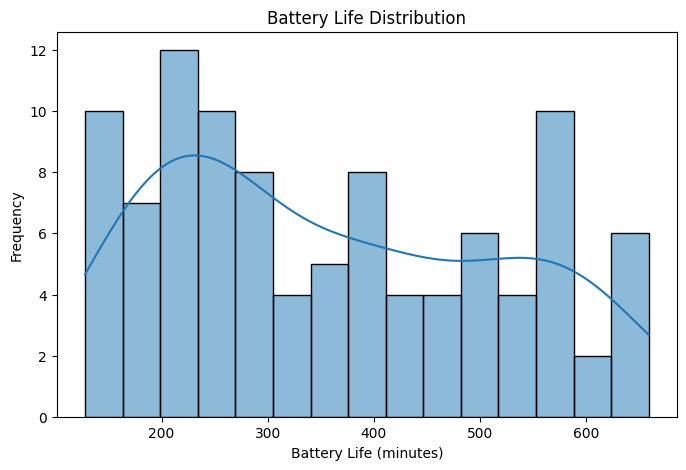

In [6]:

plt.figure(figsize=(8, 5))
sns.histplot(cleaned_df["Battery Life (min)"], bins=15, kde=True)
plt.title("Battery Life Distribution")
plt.xlabel("Battery Life (minutes)")
plt.ylabel("Frequency")
plt.show()


### 📦 Battery Life vs Task Type

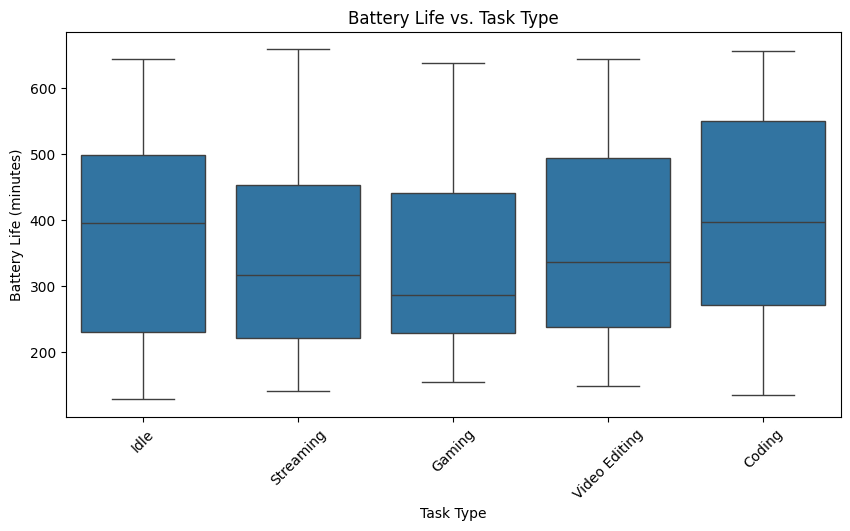

In [7]:

df_box = df.copy()
plt.figure(figsize=(10, 5))
sns.boxplot(x="Task Type", y="Battery Life (min)", data=df_box)
plt.title("Battery Life vs. Task Type")
plt.xlabel("Task Type")
plt.ylabel("Battery Life (minutes)")
plt.xticks(rotation=45)
plt.show()


### 🔥 Correlation Heatmap

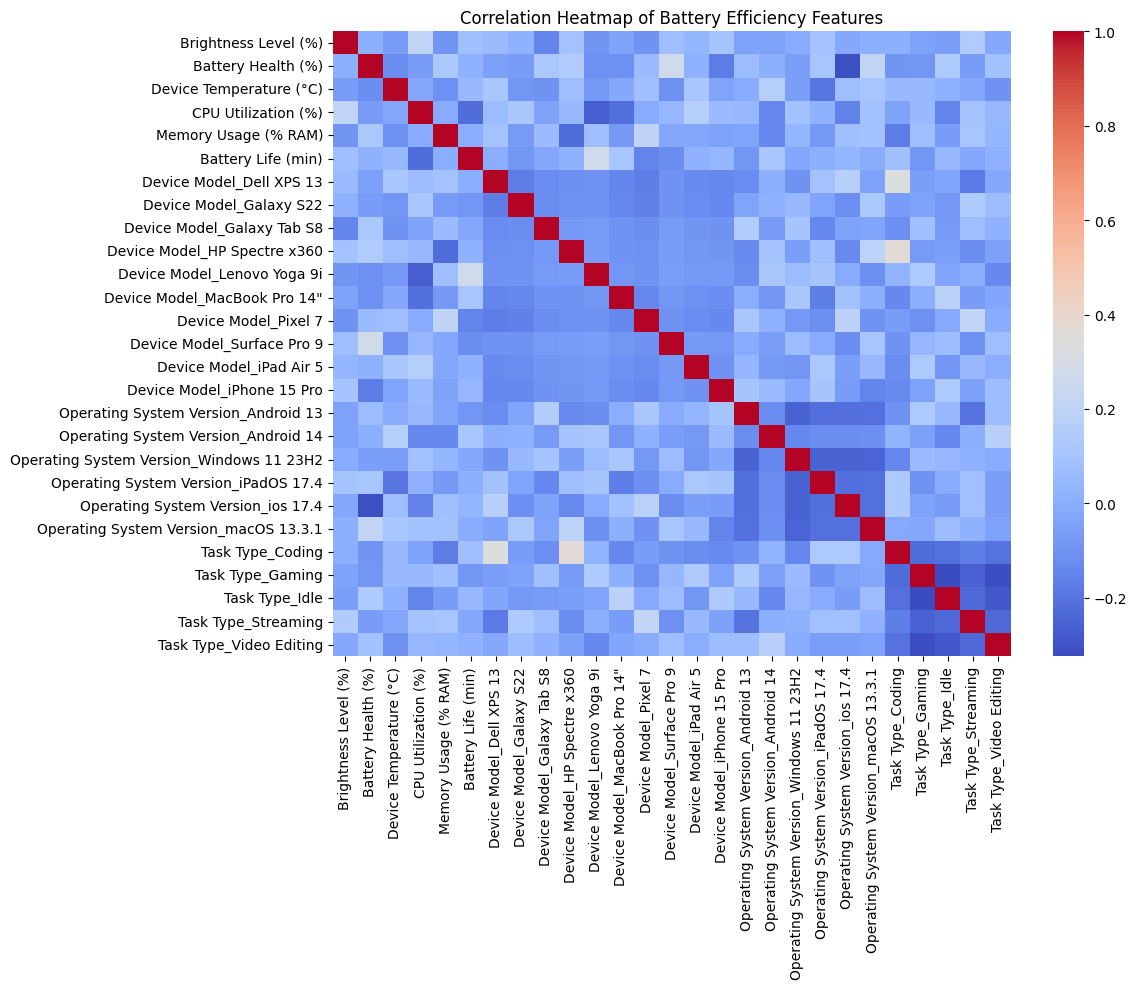

In [8]:

plt.figure(figsize=(12, 10))
sns.heatmap(cleaned_df.corr(numeric_only=True), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Battery Efficiency Features")
plt.tight_layout()
plt.show()


## 📐 Hypothesis Testing
Null Hypothesis: Task Type does not significantly affect battery life.

In [9]:

from scipy.stats import f_oneway

df_original = pd.read_csv("battery_efficiency_data.csv")
df_original["Battery Life (min)"] = df_original["Battery Life (hours:minutes)"].apply(convert_to_minutes)
df_original.dropna(subset=["Task Type", "Battery Life (min)"], inplace=True)
task_groups = df_original.groupby("Task Type")["Battery Life (min)"].apply(list)
f_stat, p_val = f_oneway(*task_groups)
print(f"F-statistic: {f_stat:.3f}")
print(f"p-value: {p_val:.3f}")


F-statistic: 0.322
p-value: 0.863


## 🤖 Linear Regression Modeling

In [10]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = cleaned_df.drop(columns=["Date of Measurement", "Battery Life (min)"])
y = cleaned_df["Battery Life (min)"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred = lr_model.predict(X_test)

print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


Mean Squared Error: 24041.78682581621
R² Score: -0.33901277012553765


### 📈 Actual vs Predicted Battery Life

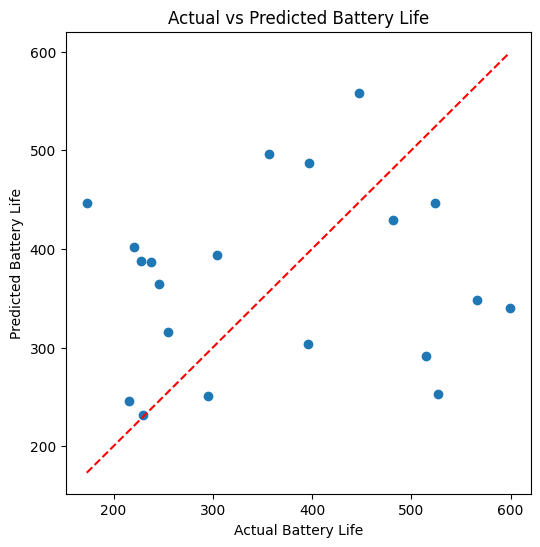

In [11]:

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Battery Life")
plt.ylabel("Predicted Battery Life")
plt.title("Actual vs Predicted Battery Life")
plt.show()


## 🔍 Classification Modeling (Random Forest)

In [12]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

def classify_life(mins):
    if mins < 240: return "Short"
    elif mins <= 360: return "Medium"
    else: return "Long"

df_class = cleaned_df.copy()
df_class["Battery Life Class"] = df_class["Battery Life (min)"].apply(classify_life)

X_cls = df_class.drop(columns=["Date of Measurement", "Battery Life (min)", "Battery Life Class"])
y_cls = df_class["Battery Life Class"]
le = LabelEncoder()
y_encoded = le.fit_transform(y_cls)

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(X_cls, y_encoded, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)
clf.fit(X_train_cls, y_train_cls)
y_pred_cls = clf.predict(X_test_cls)

print(classification_report(y_test_cls, y_pred_cls, target_names=le.classes_))


              precision    recall  f1-score   support

        Long       0.50      0.78      0.61         9
      Medium       0.50      0.20      0.29         5
       Short       0.00      0.00      0.00         6

    accuracy                           0.40        20
   macro avg       0.33      0.33      0.30        20
weighted avg       0.35      0.40      0.35        20



### 📊 Feature Importances (Top 10)

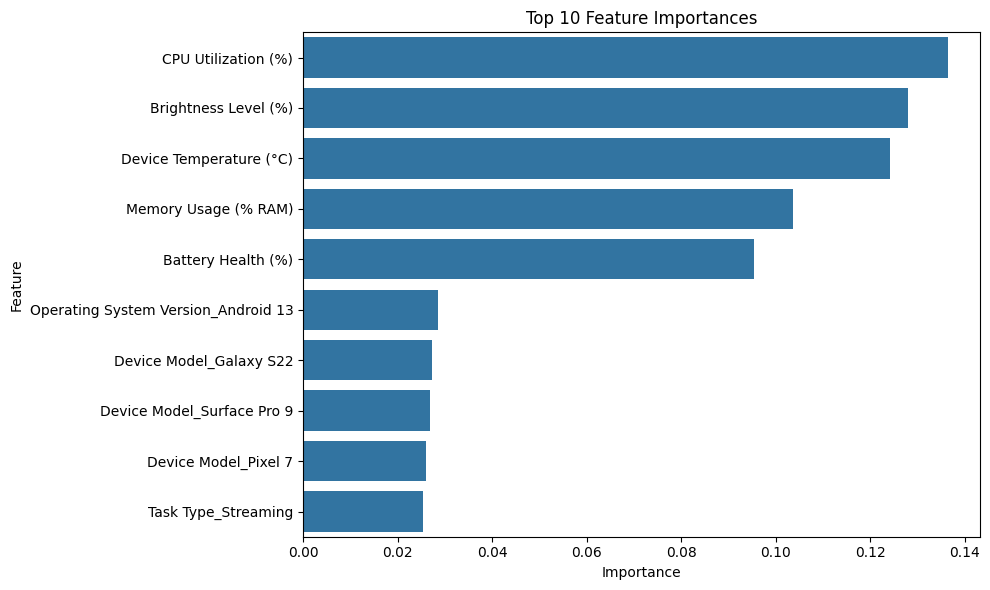

In [13]:

importances = clf.feature_importances_
feature_names = X_cls.columns
feat_imp_df = pd.DataFrame({"Feature": feature_names, "Importance": importances})
feat_imp_df.sort_values(by="Importance", ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feat_imp_df.head(10))
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## ✅ Conclusion & Future Work
- Brightness, CPU usage, and memory are moderately correlated with lower battery life.
- Linear regression had low explanatory power (R²).
- Random forest classifier achieved ~40% accuracy, mostly identifying long battery life.

### 🔮 Future Directions
- Increase dataset size
- Improve class balance for ML tasks
- Explore deep learning and time-based modeling